In [1]:
# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

In [2]:
# 忽略报错
import warnings
warnings.filterwarnings("ignore")

# 中文
plt.rcParams['font.family'] = ['Arial Unicode MS'] 

# 1. 数据概况

In [3]:
# 导入数据
red = pd.read_csv('小红书数据.csv')

In [4]:
#列名去掉前后的空格
red.columns = pd.Series(red.columns.values).apply(lambda x:x.strip()).tolist()

In [5]:
red.head()

,revenue,gender,age,engaged_last_30,lifecycle,days_since_last_order,previous_order_amount,3rd_party_stores
0,72.98,0.0,43.0,0.0,B,4.26,2343.870,0
1,200.99,0.0,34.0,0.0,A,0.94,8539.872,0
2,69.98,0.0,16.0,0.0,C,4.29,1687.646,1
3,649.99,NaN,NaN,NaN,C,14.90,3498.846,0
4,83.59,NaN,NaN,NaN,C,21.13,3968.490,4


revenue : 销售额
gender : 性别
age : 年龄
engaged_last_30 : 30天内是否参加活动
lifecycle : 用户生命周期
days_since_last_order : 最近一次下单距今天数 
previous_order_amount : 用户以往累积购买金额
3rd_party_stores : 

In [6]:
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29452 entries, 0 to 29451
Data columns (total 8 columns):
revenue                  29452 non-null float64
gender                   17723 non-null float64
age                      17723 non-null float64
engaged_last_30          17723 non-null float64
lifecycle                29452 non-null object
days_since_last_order    29452 non-null float64
previous_order_amount    29452 non-null float64
3rd_party_stores         29452 non-null int64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.8+ MB


gender, engaged_last_30, lifecycle, 3rd_party_stores 需要变成字符串类型

In [7]:
red.isnull().sum()/red.shape[0]

revenue                  0.000000
gender                   0.398241
age                      0.398241
engaged_last_30          0.398241
lifecycle                0.000000
days_since_last_order    0.000000
previous_order_amount    0.000000
3rd_party_stores         0.000000
dtype: float64

性别、年龄、最近30天参加活动与否 存在大量NaN 达到40% 需要填充

In [8]:
red.describe().drop(['gender', 'engaged_last_30', '3rd_party_stores'], axis=1)

,revenue,age,days_since_last_order,previous_order_amount
count,29452.000000,17723.000000,29452.000000,29452.000000
mean,397.071515,29.419286,7.711348,2339.254020
std,959.755615,9.213604,6.489289,2361.572921
min,0.020000,14.000000,0.130000,0.000000
25%,74.970000,21.000000,2.190000,773.349500
50%,175.980000,29.000000,5.970000,1655.790000
75%,498.772500,37.000000,11.740000,3084.796500
max,103466.100000,45.000000,23.710000,11597.900000


revenue, previous_order_amount 存在离群值，需要处理

# 2. 单变量分析

<Figure size 576x432 with 0 Axes>

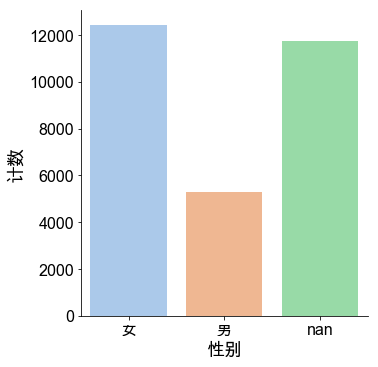

In [14]:
# 性别
plt.figure(figsize=(8,6))
data = red.gender.value_counts(dropna=False).reset_index()
data['index'] = data['index'].astype(str)
data['index'] = data['index'].map({'1.0':'男', '0.0':'女', 'nan':'nan'})
sns.catplot(x='index', y='gender', data=data, kind='bar', palette = sns.color_palette('pastel'), order = ['女', '男', 'nan'])
plt.xlabel('性别', fontsize=18)
plt.ylabel('计数', fontsize=18)
plt.tick_params(labelsize=16)

女性用户居多，NaN值若填充只能填充成Unknown

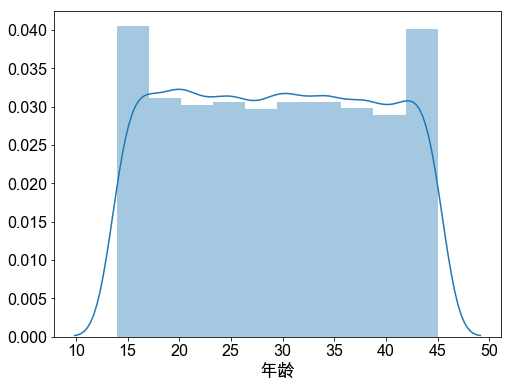

In [15]:
# 年龄
plt.figure(figsize=(8,6))
sns.distplot(red['age'].dropna(), bins = 10)
plt.xlabel('年龄', fontsize=18)
plt.tick_params(labelsize=16)

不呈正态分布趋势， 可将年龄分组

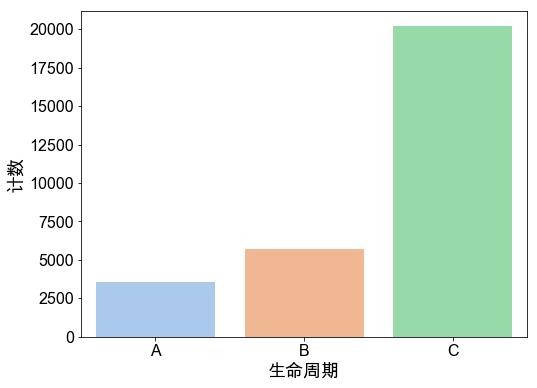

In [16]:
# 生命周期
plt.figure(figsize=(8,6))
sns.countplot(x='lifecycle', data=red, palette = sns.color_palette('pastel'), order = ['A', 'B', 'C'])
plt.xlabel('生命周期', fontsize=18)
plt.ylabel('计数', fontsize=18)
plt.tick_params(labelsize=16)

老用户多

<Figure size 576x432 with 0 Axes>

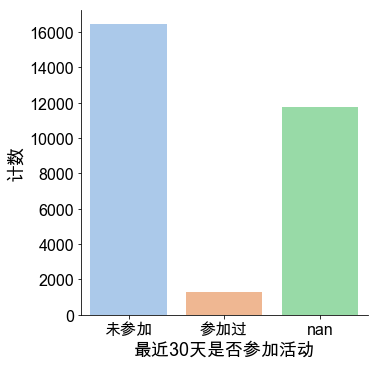

In [19]:
# 最近30天参加活动
plt.figure(figsize=(8,6))
data = red.engaged_last_30.value_counts(dropna=False).reset_index()
data['index'] = data['index'].astype(str)
data['index'] = data['index'].map({'0.0':'未参加', '1.0':'参加过', 'nan':'nan'})
sns.catplot(x='index', y='engaged_last_30', data=data, kind='bar', palette = sns.color_palette('pastel'), order=['未参加','参加过','nan'])
plt.xlabel('最近30天是否参加活动', fontsize=18)
plt.ylabel('计数', fontsize=18)
plt.tick_params(labelsize=16)

不参加活动的多，NaN值可填充为0

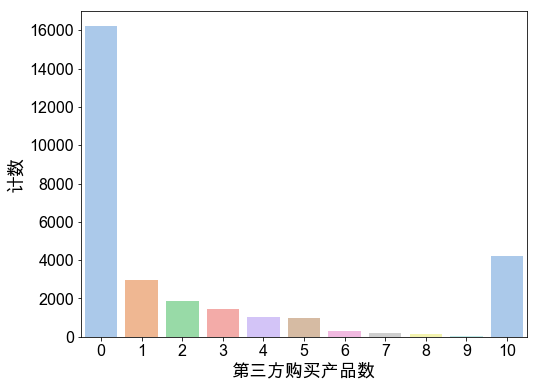

In [531]:
# 第三方购买产品数
plt.figure(figsize=(8,6))
sns.countplot(x='3rd_party_stores', data=red, palette = sns.color_palette('pastel'))
plt.xlabel('第三方购买产品数', fontsize=18)
plt.ylabel('计数', fontsize=18)
plt.tick_params(labelsize=16)

在自营平台购买的居多，其次是在第三方平台购买10个，可分组归类

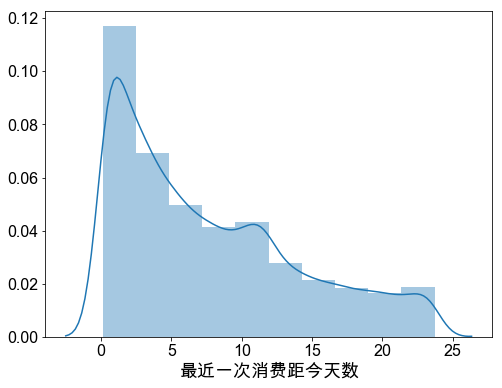

In [532]:
# 最近一次消费距今天数
plt.figure(figsize=(8,6))
sns.distplot(red['days_since_last_order'], bins=10)
plt.xlabel('最近一次消费距今天数', fontsize=18)
plt.tick_params(labelsize=16)

活跃用户居多

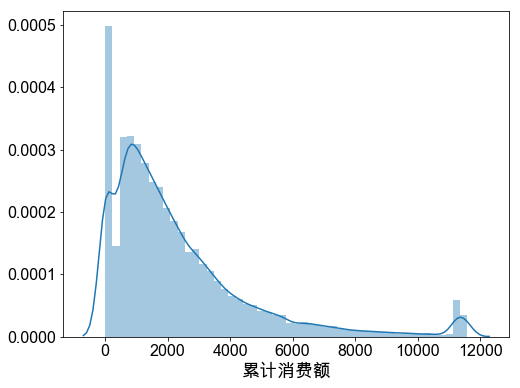

In [533]:
# 累计消费额
plt.figure(figsize=(8,6))
sns.distplot(red['previous_order_amount'])
plt.xlabel('累计消费额', fontsize=18)
plt.tick_params(labelsize=16)

尾部有离群值

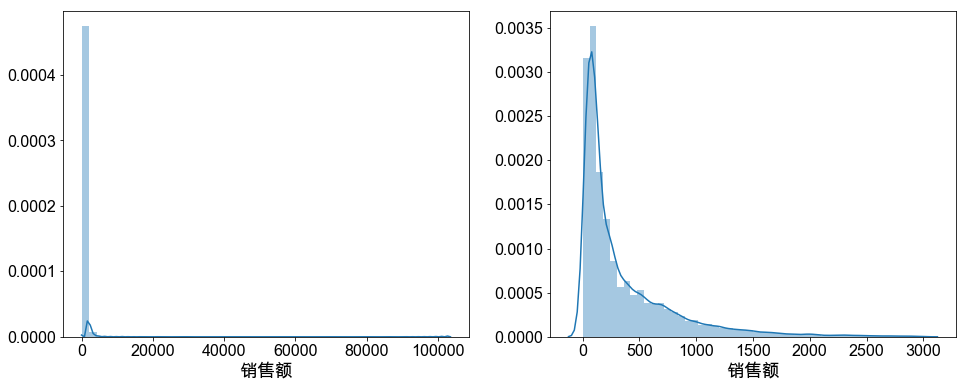

In [538]:
# 销售额
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(red['revenue'])
plt.xlabel('销售额', fontsize=18)
plt.tick_params(labelsize=16)


plt.subplot(1,2,2)
sns.distplot(red[red['revenue']<3000]['revenue'])
plt.xlabel('销售额', fontsize=18)
plt.tick_params(labelsize=16)

拖尾严重，离群值要处理

# 3. 数据处理

In [20]:
####  方案1
red_clean = red.copy()
# 缺失值处理
red_clean['age'] = red_clean['age'].fillna(red_clean['age'].mean())
red_clean['gender'] = red_clean['gender'].fillna('Unknown')
red_clean['engaged_last_30'] = red_clean['engaged_last_30'].fillna(0.0)

# 将年龄分组
bins = [10, 20, 30, 40, 50]
labels = ['<20', '<30', '<40', '<50']
red_clean['age_range'] = pd.cut(red_clean['age'], bins, right=False, labels=labels)

# 第三方购买分组
red_clean['3rd_new'] = red_clean['3rd_party_stores'].apply(lambda x:0 if x==0 else 1)

# 类别处理
red_clean['gender'] = red_clean['gender'].astype(str)
red_clean['engaged_last_30'] = red_clean['engaged_last_30'].astype(str)
red_clean['3rd_new'] = red_clean['3rd_new'].astype(str)
red_clean['lifecycle'] = red_clean['lifecycle'].astype(str)
red_clean['age_range'] = red_clean['age_range'].astype(str)

# revenue 离群值处理
coeff = 1.5
threshold = red_clean['revenue'].describe()['75%'] + (red_clean['revenue'].describe()['75%'] - red_clean['revenue'].describe()['25%']) * coeff
red_clean.drop(red_clean[red_clean['revenue']>threshold].index, inplace=True)
print("已删除 %d 行， 占比 %f" % (red.shape[0]-red_clean.shape[0], (red.shape[0]-red_clean.shape[0])/red.shape[0]))

# previous_order_amount 离群值处理
threshold_1 = red_clean['previous_order_amount'].describe()['75%'] + (red_clean['previous_order_amount'].describe()['75%'] - red_clean['previous_order_amount'].describe()['25%']) * coeff
red_clean.drop(red_clean[red_clean['previous_order_amount']>threshold_1].index, inplace=True)
print("总共删除 %d 行， 占比 %f" % (red.shape[0]-red_clean.shape[0], (red.shape[0]-red_clean.shape[0])/red.shape[0]))

已删除 2167 行， 占比 0.073577
总共删除 3814 行， 占比 0.129499


In [75]:
##### 方案2
red_clean = red.copy()
# 缺失值处理
red_clean['age'] = red_clean['age'].fillna(red_clean['age'].mean())
red_clean['gender'] = red_clean['gender'].fillna('Unknown')
red_clean['engaged_last_30'] = red_clean['engaged_last_30'].fillna(0.0)

# 将年龄分组
bins = [10, 20, 30, 40, 50]
labels = ['<20', '<30', '<40', '<50']
red_clean['age_range'] = pd.cut(red_clean['age'], bins, right=False, labels=labels)

# 第三方购买分组
red_clean['3rd_new'] = red_clean['3rd_party_stores'].apply(lambda x:0 if x==0 else 1)

# 类别处理
red_clean['gender'] = red_clean['gender'].astype(str)
red_clean['engaged_last_30'] = red_clean['engaged_last_30'].astype(str)
red_clean['3rd_new'] = red_clean['3rd_new'].astype(str)
red_clean['lifecycle'] = red_clean['lifecycle'].astype(str)
red_clean['age_range'] = red_clean['age_range'].astype(str)

In [86]:
####  方案3
red_clean = red.copy()
# 缺失值处理
red_clean['age'] = red_clean['age'].fillna(red_clean['age'].mean())
red_clean['gender'] = red_clean['gender'].fillna('Unknown')
red_clean['engaged_last_30'] = red_clean['engaged_last_30'].fillna(0.0)

# 将年龄分组
bins = [10, 20, 30, 40, 50]
labels = ['<20', '<30', '<40', '<50']
red_clean['age_range'] = pd.cut(red_clean['age'], bins, right=False, labels=labels)

# 第三方购买分组
red_clean['3rd_new'] = red_clean['3rd_party_stores'].apply(lambda x:0 if x==0 else 1)

# 类别处理
red_clean['gender'] = red_clean['gender'].astype(str)
red_clean['engaged_last_30'] = red_clean['engaged_last_30'].astype(str)
red_clean['3rd_new'] = red_clean['3rd_new'].astype(str)
red_clean['lifecycle'] = red_clean['lifecycle'].astype(str)
red_clean['age_range'] = red_clean['age_range'].astype(str)

# revenue 离群值处理
coeff = 3
threshold = red_clean['revenue'].describe()['75%'] + (red_clean['revenue'].describe()['75%'] - red_clean['revenue'].describe()['25%']) * coeff
red_clean.drop(red_clean[red_clean['revenue']>threshold].index, inplace=True)
print("已删除 %d 行， 占比 %f" % (red.shape[0]-red_clean.shape[0], (red.shape[0]-red_clean.shape[0])/red.shape[0]))

# previous_order_amount 离群值处理
threshold_1 = red_clean['previous_order_amount'].describe()['75%'] + (red_clean['previous_order_amount'].describe()['75%'] - red_clean['previous_order_amount'].describe()['25%']) * coeff
red_clean.drop(red_clean[red_clean['previous_order_amount']>threshold_1].index, inplace=True)
print("总共删除 %d 行， 占比 %f" % (red.shape[0]-red_clean.shape[0], (red.shape[0]-red_clean.shape[0])/red.shape[0]))

已删除 783 行， 占比 0.026586
总共删除 1450 行， 占比 0.049233


采用方案一作下面的分析，方案二和方案三为模型优化的尝试。

# 3. 多变量分析

<Figure size 576x432 with 0 Axes>

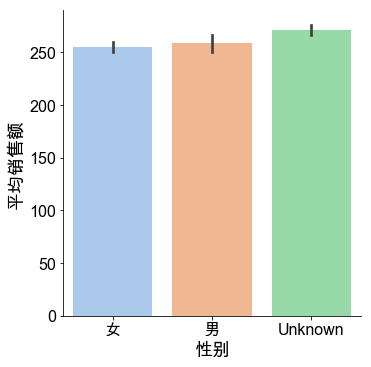

In [24]:
# 性别和销售额
plt.figure(figsize=(8,6))
data = red_clean[['gender', 'revenue']]
data['gender'] = data['gender'].map({"0.0":'女', '1.0':'男','Unknown':'Unknown'})
sns.catplot(x='gender', y='revenue', kind='bar', data=data, palette=sns.color_palette('pastel'), order=['女', '男', 'Unknown'])
plt.xlabel('性别', fontsize=18)
plt.ylabel('平均销售额', fontsize=18)
plt.tick_params(labelsize=16)

男性稍微高于女性，未知姓名均值最高

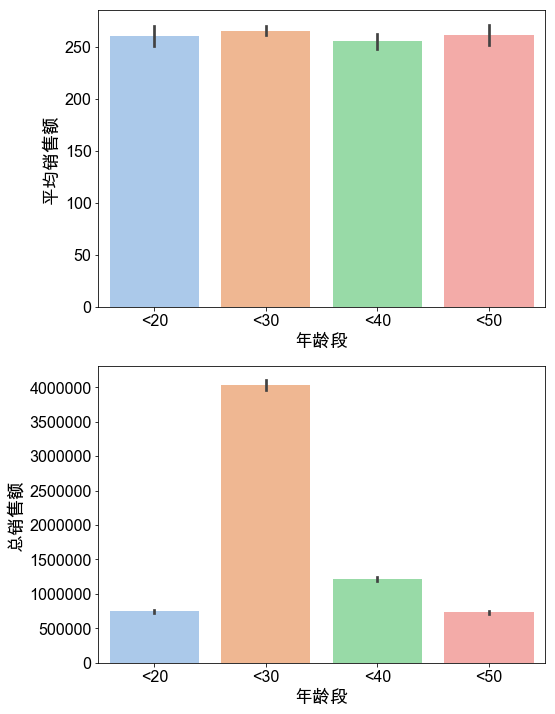

In [545]:
# 年龄段与销售额
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
sns.barplot(x='age_range', y='revenue', data=red_clean, palette=sns.color_palette('pastel'), order=labels)
plt.xlabel('年龄段', fontsize=18)
plt.ylabel('平均销售额', fontsize=18)
plt.tick_params(labelsize=16)

plt.subplot(2,1,2)
sns.barplot(x='age_range', y='revenue', data=red_clean, palette=sns.color_palette('pastel'), order=labels, estimator=np.sum)
plt.xlabel('年龄段', fontsize=18)
plt.ylabel('总销售额', fontsize=18)
plt.tick_params(labelsize=16)

30-40岁之间均值最低

<Figure size 576x432 with 0 Axes>

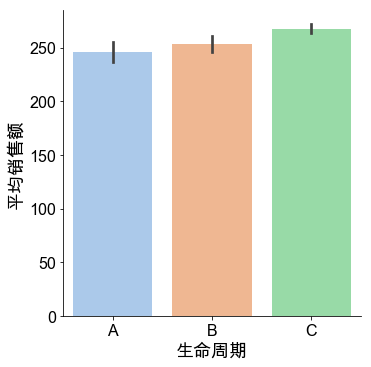

In [324]:
# 生命周期与销售额
plt.figure(figsize=(8,6))
sns.catplot(x='lifecycle', y='revenue', kind='bar', data=red_clean, palette=sns.color_palette('pastel'), order=['A','B','C'])
plt.xlabel('生命周期', fontsize=18)
plt.ylabel('平均销售额', fontsize=18)
plt.tick_params(labelsize=16)

用户注册时间越长，均值越高

<Figure size 576x432 with 0 Axes>

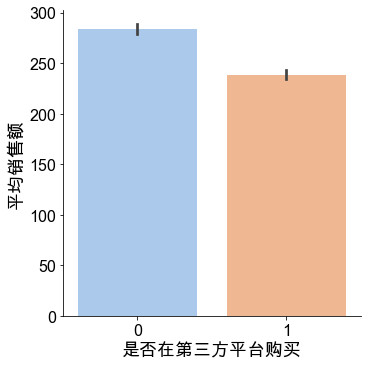

In [356]:
# 第三方购买
plt.figure(figsize=(8,6))
sns.catplot(x='3rd_new', y='revenue', kind='bar', data=red_clean, palette=sns.color_palette('pastel'))
plt.xlabel('是否在第三方平台购买', fontsize=18)
plt.ylabel('平均销售额', fontsize=18)
plt.tick_params(labelsize=16)

在自营平台购买销售额均值更高

<Figure size 576x432 with 0 Axes>

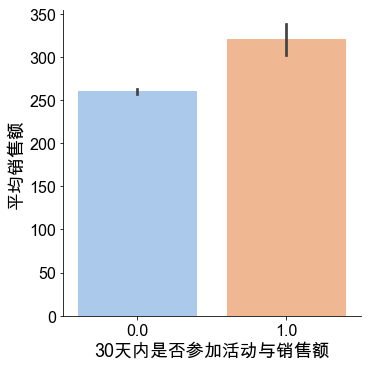

In [357]:
# 是否参加活动与销售额
plt.figure(figsize=(8,6))
sns.catplot(x='engaged_last_30', y='revenue', kind='bar', data=red_clean, palette=sns.color_palette('pastel'))
plt.xlabel('30天内是否参加活动与销售额', fontsize=18)
plt.ylabel('平均销售额', fontsize=18)
plt.tick_params(labelsize=16)

30天内参加活动的销售额均值更高

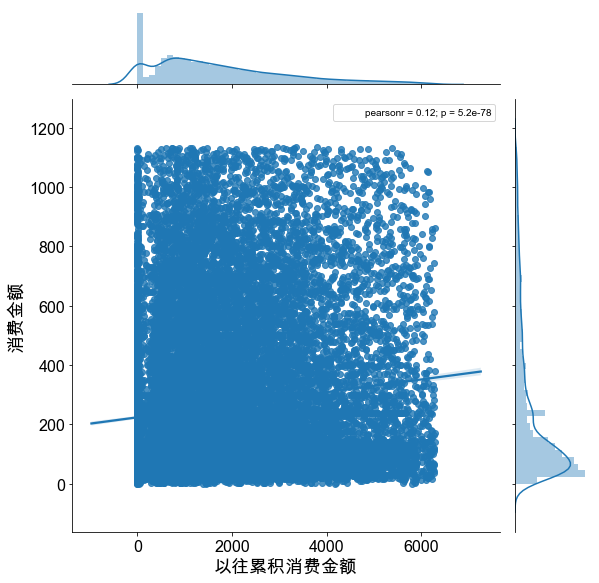

In [549]:
import scipy.stats as sci
def pearson(x,y):
    r,p = stats.pearsonr(x,y)
    
sns.jointplot(x='previous_order_amount', y='revenue', data=red_clean, kind='reg', stat_func=sci.pearsonr, marginal_kws=dict(bins=50), size=8)
plt.xlabel('以往累积消费金额', fontsize=18)
plt.ylabel('消费金额', fontsize=18)
plt.tick_params(labelsize=16)

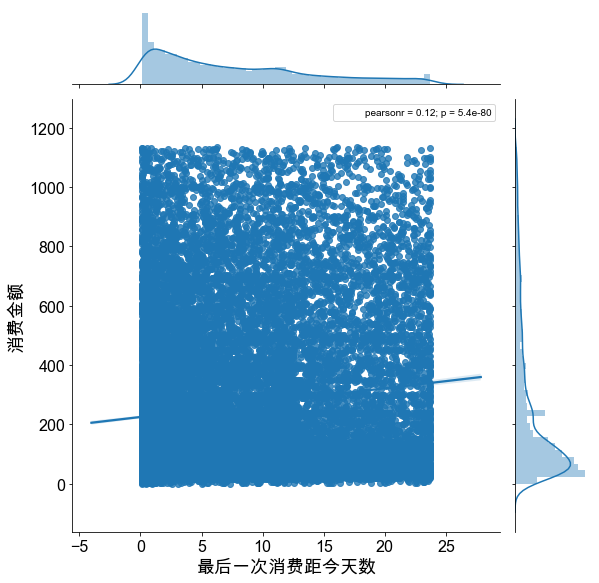

In [548]:
import scipy.stats as sci
def pearson(x,y):
    r,p = stats.pearsonr(x,y)
    
sns.jointplot(x='days_since_last_order', y='revenue', data=red_clean, kind='reg', stat_func=sci.pearsonr, marginal_kws=dict(bins=50), size=8)
plt.xlabel('最后一次消费距今天数', fontsize=18)
plt.ylabel('消费金额', fontsize=18)
plt.tick_params(labelsize=16)

In [550]:
red_clean.corr()[['revenue']].sort_values('revenue', ascending=False)

,revenue
revenue,1.000000
days_since_last_order,0.117874
previous_order_amount,0.116378
age,0.003108
3rd_party_stores,-0.048588


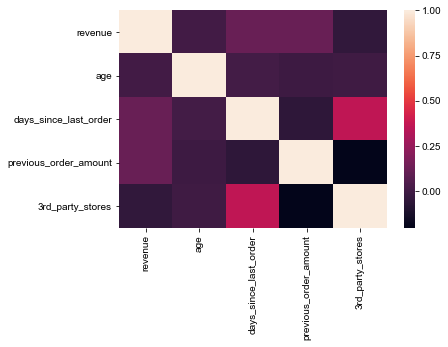

In [551]:
sns.heatmap(red_clean.corr())

# 4. 回归模型建立

In [87]:
# 变量转化
red_clean = pd.get_dummies(red_clean, drop_first=True)
red_clean.head()

,revenue,age,days_since_last_order,previous_order_amount,3rd_party_stores,gender_1.0,gender_Unknown,engaged_last_30_1.0,lifecycle_B,lifecycle_C,age_range_<30,age_range_<40,age_range_<50,3rd_new_1
0,72.98,43.000000,4.26,2343.870,0,0,0,0,1,0,0,0,1,0
1,200.99,34.000000,0.94,8539.872,0,0,0,0,0,0,0,1,0,0
2,69.98,16.000000,4.29,1687.646,1,0,0,0,0,1,0,0,0,1
3,649.99,29.419286,14.90,3498.846,0,0,1,0,0,1,1,0,0,0
4,83.59,29.419286,21.13,3968.490,4,0,1,0,0,1,1,0,0,1


In [88]:
red_clean.corr()[['revenue']].sort_values('revenue', ascending=False)

,revenue
revenue,1.000000
previous_order_amount,0.140094
days_since_last_order,0.111772
engaged_last_30_1.0,0.041769
lifecycle_C,0.022333
gender_Unknown,0.020397
age_range_<30,0.009869
age_range_<50,-0.000479
age,-0.000561
gender_1.0,-0.003917


In [89]:
# 定义自变量和因变量
var = ['days_since_last_order', 'previous_order_amount', 'engaged_last_30_1.0', 'lifecycle_C', 'gender_Unknown', 'age_range_<30', '3rd_new_1']
y = red_clean['revenue']
X = red_clean[var]
#X = red_clean.drop('revenue', axis=1)

In [90]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 200)

In [91]:
# 标准化数据
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [92]:
# 训练模型
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
print("训练集打分：%.5f"%model.score(X_train, y_train))
print("测试集打分：%.5f"%model.score(X_test, y_test))

训练集打分：0.04921
测试集打分：0.04815


In [94]:
for a, b in zip(np.append(var, 'intercept'), np.append(model.coef_,model.intercept_)):
    print("%s : %.3f" % (a,b))

days_since_last_order : 51.805
previous_order_amount : 44.077
engaged_last_30_1.0 : 11.879
lifecycle_C : 12.514
gender_Unknown : 11.983
age_range_<30 : -4.264
3rd_new_1 : -49.076
intercept : 318.173


In [95]:
# 计算残差
y_pred = model.predict(X_test)
error = y_pred - y_test
rmse = (error**2).mean()**.5
mae = abs(error).mean()
print("RMSE = %.3f, MAE = %.3f" % (rmse, mae))

RMSE = 342.371, MAE = 257.292


In [96]:
model_ols=ols('y~X',red_clean).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     206.0
Date:                Thu, 30 Apr 2020   Prob (F-statistic):          1.54e-299
Time:                        00:20:27   Log-Likelihood:            -2.0333e+05
No. Observations:               28002   AIC:                         4.067e+05
Df Residuals:                   27994   BIC:                         4.067e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    223.6073      5.294     42.240      0.000     213.231     233.983
X[0]           7.7830      0.406     19.171      0.000       6.987       8.579
X[1]           0.0244      0.001     21.388      0.000       0.022       0.027
X[2]          65.6501     10.912      6.016      0.000      44.262      87.038
X[3]          24.6683      6.792      3.632      0.000      11.356      37.981
X[4]          25.8933      5.812      4.455      0.000      14.502      37.285
X[5]          -3.9916      5.724     -0.697      0.486     -15.210       7.227
X[6]         -96.3159      5.320    -18.105      0.000    -106.743     -85.889
==============================================================================
Omnibus:                     8424.924   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21233.641
Skew:                           1.671   Prob(JB):                         0.00
Kurtosis:                       5.653   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

------------------------------------------分割线----------------------------------------------

模型优化------Part 1 自变量的改变

In [62]:
# 1. 放入全部变量
X = red_clean.drop('revenue', axis=1)
y = red_clean['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 200)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [63]:
print("训练集打分：%.5f"%model.score(X_train, y_train))
print("测试集打分：%.5f"%model.score(X_test, y_test))

训练集打分：0.04660
测试集打分：0.04221


In [64]:
print(model.coef_)
print(model.intercept_)

[ -6.08786269  35.64582963  29.15813465   1.57144019  -0.49930219
  14.95665203  11.08497066  -1.47759759  10.90043972  -4.15421405
   0.12510824   4.42517493 -40.50376483]
262.3136852780564


In [65]:
# 计算残差
y_pred = model.predict(X_test)
error = y_pred - y_test
rmse = (error**2).mean()**.5
mae = abs(error).mean()
print("RMSE = %.3f, MAE = %.3f" % (rmse, mae))

RMSE = 260.592, MAE = 203.711


In [66]:
# 2. 筛选变量
var = ['days_since_last_order', 'previous_order_amount', 'engaged_last_30_1.0',  'lifecycle_C', 'gender_Unknown', '3rd_new_1']
X = red_clean[var]
y = red_clean['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 200)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
print("训练集打分：%.5f"%model.score(X_train, y_train))
print("测试集打分：%.5f"%model.score(X_test, y_test))

训练集打分：0.04623
测试集打分：0.04342


In [68]:
print(model.coef_)
print(model.intercept_)

[ 35.73517574  29.07757422  11.14651769  11.98359558  11.05406187
 -39.39860213]
262.3136852780564


In [70]:
# 计算残差
y_pred = model.predict(X_test)
error = y_pred - y_test
rmse = (error**2).mean()**.5
mae = abs(error).mean()
print("RMSE = %.3f, MAE = %.3f" % (rmse, mae))

RMSE = 260.428, MAE = 203.654


模型优化------Part 2 数据处理时不对revenue和previous_order_amount的离群值进行操作
转至3. 数据处理 
运行方案2
再转至4. 回归模型建立
运行至分割线处

模型优化------Part 3 数据处理时改变对revenue和previous_order_amount离群值的操作
转至3. 数据处理 
运行方案3
再转至4. 回归模型建立
运行至分割线处